## 批量归一化

当网络模型过深的时候，由于乘法原则在靠近输入层的梯度将非常小，因此靠近输入层的参数不能及时的得到更新，这会影响模型的收敛速度。

为什么需要批量归一化？

- 在数据预处理阶段，首先要进行标准化特征值，使得平均值为0，方差为1，将参数的量级进行统一，便于优化器优化。

- 更深层的网络很复杂，更容易过拟合，批量归一化可以应用于单个可选层，也可以应用于所有层，原理为：在每次迭代中，首先对输入进行归一化，通过减去均值并除以标准差，然后应用比例系数和比例偏移。

用$\mathbf{x} \in \mathcal{B}$表示一个来自小批量$\mathcal{B}$的输入，批量归一化$\mathcal{BN}$可以表示为:
$$\mathrm{BN}\mathbf{(x)}=\gamma \odot \frac{\mathbf{x} - \hat{\mu}_{\beta}}{\hat{\sigma_{\beta}}} + \beta.$$

其中$\hat{\mu}_{\beta}$是样本均值，$\hat{\sigma}_{\beta}$是批量的岩本标准差，由于单位方差是一个任意的选择，因此我们通常包含拉伸参数（scale）$\gamma$和偏移参数（shift）$\beta$。

$$\begin{aligned} \hat{\mu}_{\beta} &= \frac{1}{|\beta|}\sum_{x\in\beta}\mathbf{x},\\ \hat{\sigma}_{\beta}^2&=\frac{1}{|\beta|}\sum_{x\in\beta}(x-\hat{\mu}_\beta)^2+\epsilon.\end{aligned} $$

其中$\epsilon > 0$确保不会除零。

### 全连接层

通常将批量归一化放到放射函数和激活函数之间，即$h = \phi(\mathrm{BN}(\mathbf{Wx+b}))$.

### 卷积层

对于卷积层，通常在卷积层之后和非线性激活函数之前应用批量归一化。卷积层有多个通道，每个通道有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量，假设有$m$个样例，输出的高为$p$宽为$q$，那么对于每个通道的$m\cdot p \cdot q$个元素同时执行批量归一化。

### 预测过程中的批量归一化
预测的时候直接使用整体的均值和方差。

## 从零实现

In [28]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enable判断当前模式（训练、预测）
    if not torch.is_grad_enabled(): # 预测模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else: # 训练模式
        assert(len(X.shape) in (2, 4)) # 默认支持全连接层和二维卷积层的归一化
        if len(X.shape) == 2: # 全连接层
            # 计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else: # 卷积层
            # 计算通道维上的均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 计算训练模式下的归一化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var

    Y = gamma * X_hat + beta
    # return Y, moving_mean.data, moving_var.data
    return Y, moving_mean, moving_var

In [29]:
class BatchNorm(nn.Module):
    # num_features: 全连接层表示输出数量，卷积层表示输出通道数
    # num_dims: 2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与梯度计算的拉伸和偏移初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # copy to X.device
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9
        )
        return Y

In [17]:
# 使用批量归一化的LeNet
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
           nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
           nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
           BatchNorm(120, num_dims=2), nn.Sigmoid(),
           nn.Linear(120, 84), BatchNorm(84, num_dims=2),
           nn.Sigmoid(), nn.Linear(84, 10))

loss 0.231, train acc 0.914, test acc 0.879
23465.8 examples/sec on cuda:0


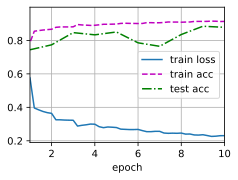

In [30]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [35]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.8709, 2.1780, 2.2029, 2.9381, 1.5822, 3.5365], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([ 1.1218, -3.1657,  0.5544,  0.3028, -1.1314, -3.8449], device='cuda:0',
        grad_fn=<ViewBackward>))

## 简明实现


In [38]:
# 使用深度学习框架定义的BatchNorm。
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
           nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
           nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
           nn.BatchNorm1d(120), nn.Sigmoid(),
           nn.Linear(120, 84), nn.BatchNorm1d(84),
           nn.Sigmoid(), nn.Linear(84, 10))

loss 0.253, train acc 0.907, test acc 0.865
35207.3 examples/sec on cuda:0


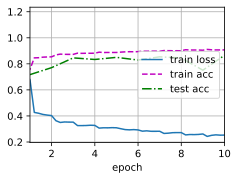

In [39]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

使用高级API的运行速度要快一些，因为代码已编译为C++或CUDA，而自定义的是由Python实现。

In [4]:
!nvidia-smi

Sat Jul 31 15:58:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------